# 12 - Ensemble Methods - Random Forest


by [Alejandro Correa Bahnsen](albahnsen.com/) and [Jesus Solano](https://github.com/jesugome)

version 1.5, February 2019

## Part of the class [Practical Machine Learning](https://github.com/albahnsen/PracticalMachineLearningClass)



This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Kevin Markham](https://github.com/justmarkham))

Why are we learning about ensembling?

- Very popular method for improving the predictive performance of machine learning models
- Provides a foundation for understanding more sophisticated models

## Lesson objectives

Students will be able to:

- Explain the difference between bagged trees and Random Forests
- Build and tune a Random Forest model in scikit-learn
- Decide whether a decision tree or a Random Forest is a better model for a given problem

# Part 1: Random Forests

Random Forests is a **slight variation of bagged trees** that has even better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **Random Forests "decorrelates" the trees**, such that the averaging process can reduce the variance of the resulting model.

# Part 2: Building and tuning decision trees and Random Forests

- Major League Baseball player data from 1986-87: [data](https://github.com/justmarkham/DAT8/blob/master/data/hitters.csv), [data dictionary](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) (page 7)
- Each observation represents a player
- **Goal:** Predict player salary

In [1]:
import pandas as pd
import numpy as np

# read in the data
url = 'https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/datasets/hitters.csv'
hitters = pd.read_csv(url)

# remove rows with missing values
hitters.dropna(inplace=True)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [2]:
# encode categorical variables as integers
hitters['League'] = pd.factorize(hitters.League)[0]
hitters['Division'] = pd.factorize(hitters.Division)[0]
hitters['NewLeague'] = pd.factorize(hitters.NewLeague)[0]
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,0,1,805,40,4,91.5,0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,1,0,282,421,25,750.0,1


In [3]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

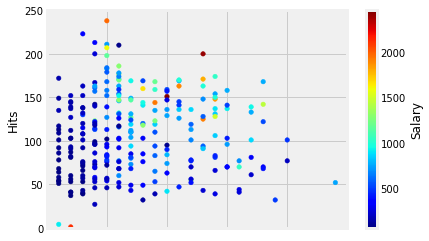

In [4]:
# scatter plot of Years versus Hits colored by Salary
hitters.plot(kind='scatter', x='Years', y='Hits', c='Salary', colormap='jet', xlim=(0, 25), ylim=(0, 250))

In [5]:
# define features: exclude career statistics (which start with "C") and the response (Salary)
feature_cols = hitters.columns[hitters.columns.str.startswith('C') == False].drop('Salary')
feature_cols

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')

In [6]:
# define X and y
X = hitters[feature_cols]
y = hitters.Salary

## Predicting salary with a decision tree

Find the best **max_depth** for a decision tree using cross-validation:

In [7]:
# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10,scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Text(0, 0.5, 'RMSE (lower is better)')

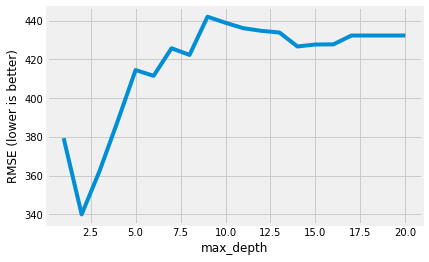

In [8]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [9]:
# show the best RMSE and the corresponding max_depth
sorted(zip(RMSE_scores, max_depth_range))[0]

(340.034168704752, 2)

In [10]:
# max_depth=2 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth=2, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [11]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_}).sort_values('importance')

,feature,importance
0,AtBat,0.000000
2,HmRun,0.000000
3,Runs,0.000000
4,RBI,0.000000
5,Walks,0.000000
7,League,0.000000
8,Division,0.000000
9,PutOuts,0.000000
10,Assists,0.000000
11,Errors,0.000000


## Predicting salary with a Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Tuning n_estimators

One important tuning parameter is **n_estimators**, which is the number of trees that should be grown. It should be a large enough value that the error seems to have "stabilized".

In [13]:
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Text(0, 0.5, 'RMSE (lower is better)')

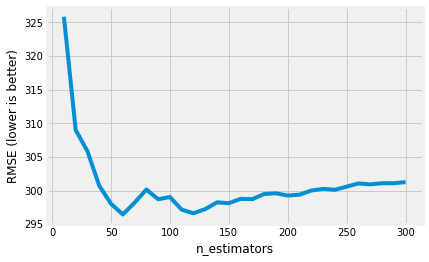

In [14]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

### Tuning max_features

The other important tuning parameter is **max_features**, which is the number of features that should be considered at each split.

In [15]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1, n_jobs=-1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Text(0, 0.5, 'RMSE (lower is better)')

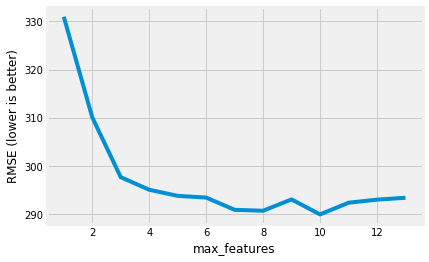

In [16]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

In [17]:
# show the best RMSE and the corresponding max_features
sorted(zip(RMSE_scores, feature_range))[0]

(290.0078511328435, 10)

### Fitting a Random Forest with the best parameters

In [18]:
# max_features=8 is best and n_estimators=150 is sufficiently large
rfreg = RandomForestRegressor(n_estimators=150, max_features=8, oob_score=True, random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=None, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [19]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values('importance')

,feature,importance
7,League,0.003603
12,NewLeague,0.004290
8,Division,0.005477
10,Assists,0.023842
11,Errors,0.028618
2,HmRun,0.044607
9,PutOuts,0.060063
3,Runs,0.071800
0,AtBat,0.094592
4,RBI,0.130965


In [20]:
# compute the out-of-bag R-squared score
rfreg.oob_score_

0.5274187002769267

### Reducing X to its most important features


In [21]:
# check the shape of X
X.shape

(263, 13)

In [22]:
from sklearn.feature_selection import SelectFromModel

# set a threshold for which features to include

myThreshold = 0.1
sfm = SelectFromModel(rfreg, threshold=myThreshold)
# Train the selector
sfm.fit(X, y)
print('Threshold = ', myThreshold,' ---> Number of selected features:', np.count_nonzero( sfm.get_support() == True))


myThreshold = 'mean'
sfm = SelectFromModel(rfreg, threshold=myThreshold)
# Train the selector
sfm.fit(X, y)
print('Threshold = ', myThreshold,' ---> Number of selected features:', np.count_nonzero( sfm.get_support() == True))

myThreshold = 'median'
sfm = SelectFromModel(rfreg, threshold=myThreshold)
# Train the selector
sfm.fit(X, y)
print('Threshold = ', myThreshold,' ---> Number of selected features:', np.count_nonzero( sfm.get_support() == True))


Threshold =  0.1  ---> Number of selected features: 4
Threshold =  mean  ---> Number of selected features: 5
Threshold =  median  ---> Number of selected features: 7


In [23]:
# create a new feature matrix that only includes important features
myThreshold = 'mean'
sfm = SelectFromModel(rfreg, threshold=myThreshold)
# Train the selector
sfm.fit(X, y)
X_important = sfm.transform(X)

In [24]:
# check the RMSE for a Random Forest that only includes important features
rfreg = RandomForestRegressor(n_estimators=150, max_features=3, random_state=1)
scores = cross_val_score(rfreg, X_important, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

284.35550515135395

## Comparing Random Forests with decision trees

**Advantages of Random Forests:**

- Performance is competitive with the best supervised learning methods
- Provides a more reliable estimate of feature importance
- Allows you to estimate out-of-sample error without using train/test split or cross-validation

**Disadvantages of Random Forests:**

- Less interpretable
- Slower to train
- Slower to predict

![Machine learning flowchart](https://raw.githubusercontent.com/justmarkham/DAT8/master/notebooks/images/driver_ensembling.png)

*Machine learning flowchart created by the [second place finisher](http://blog.kaggle.com/2015/04/20/axa-winners-interview-learning-telematic-fingerprints-from-gps-data/) of Kaggle's [Driver Telematics competition](https://www.kaggle.com/c/axa-driver-telematics-analysis)*